In [1]:
import os 

import numpy as np
import scipy.stats as sps
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import sys, os
sys.path += [os.path.abspath(os.pardir + '/src')]
print(sys.path)

from experiment import init_random_state, BanditLoopExperiment, get_ts_model

sns.set(font_scale=1.2, palette='tab20') 

['/home/anton/Desktop/m1p/2021-Project-74/notebooks', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/anton/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/local/lib/python3.8/dist-packages/simpleeval-0.9.10-py3.8.egg', '/usr/local/lib/python3.8/dist-packages/sh-1.13.1-py3.8.egg', '/usr/local/lib/python3.8/dist-packages/mldev-0.3.dev2-py3.8.egg', '/usr/lib/python3/dist-packages', '/home/anton/.local/lib/python3.8/site-packages/IPython/extensions', '/home/anton/.ipython', '/home/anton/Desktop/m1p/2021-Project-74/src']


In [8]:
seed = 42

p = 0.9
Q = 1
w = 2
bs = np.linspace(0, 1, 5)

T = 5000
M = 10
l = 4

In [9]:
interests, TS_paramss, responses = [], [], []

In [10]:
for b in tqdm(bs):
    init_random_state(seed)
    
    bandit = lambda: get_ts_model(M=M, l=l)
    exp = BanditLoopExperiment(bandit, "TS bandit")
    exp.prepare(w=w, Q=Q, p=p, b=b)
    exp.run_experiment(T=T)
    
    results = exp.get_as_np()
    interests.append(results.interest)
    TS_paramss.append(results.TS_params)
    responses.append(results.response)

100%|██████████| 5/5 [00:56<00:00, 11.32s/it]


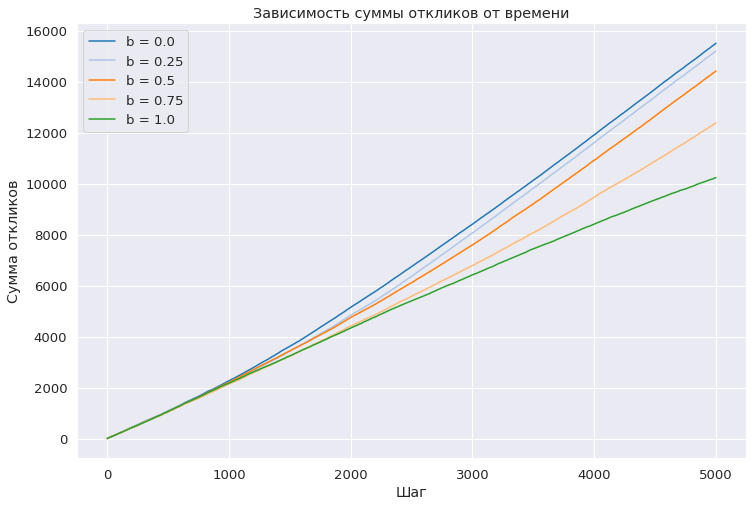

In [11]:
sum_responces = []
for  i, b in enumerate(bs):
    sum_responces.append(np.cumsum(responses[i].sum(axis=1)))
plt.figure(figsize=(12, 8))
for i, b in enumerate(bs):
    plt.plot(np.arange(1, T+1), sum_responces[i], label=f'b = {round(b,3)}')

plt.title('Зависимость суммы откликов от времени')
plt.ylabel('Сумма откликов')
plt.xlabel('Шаг')
plt.legend()
# plt.savefig('rewards.pdf')

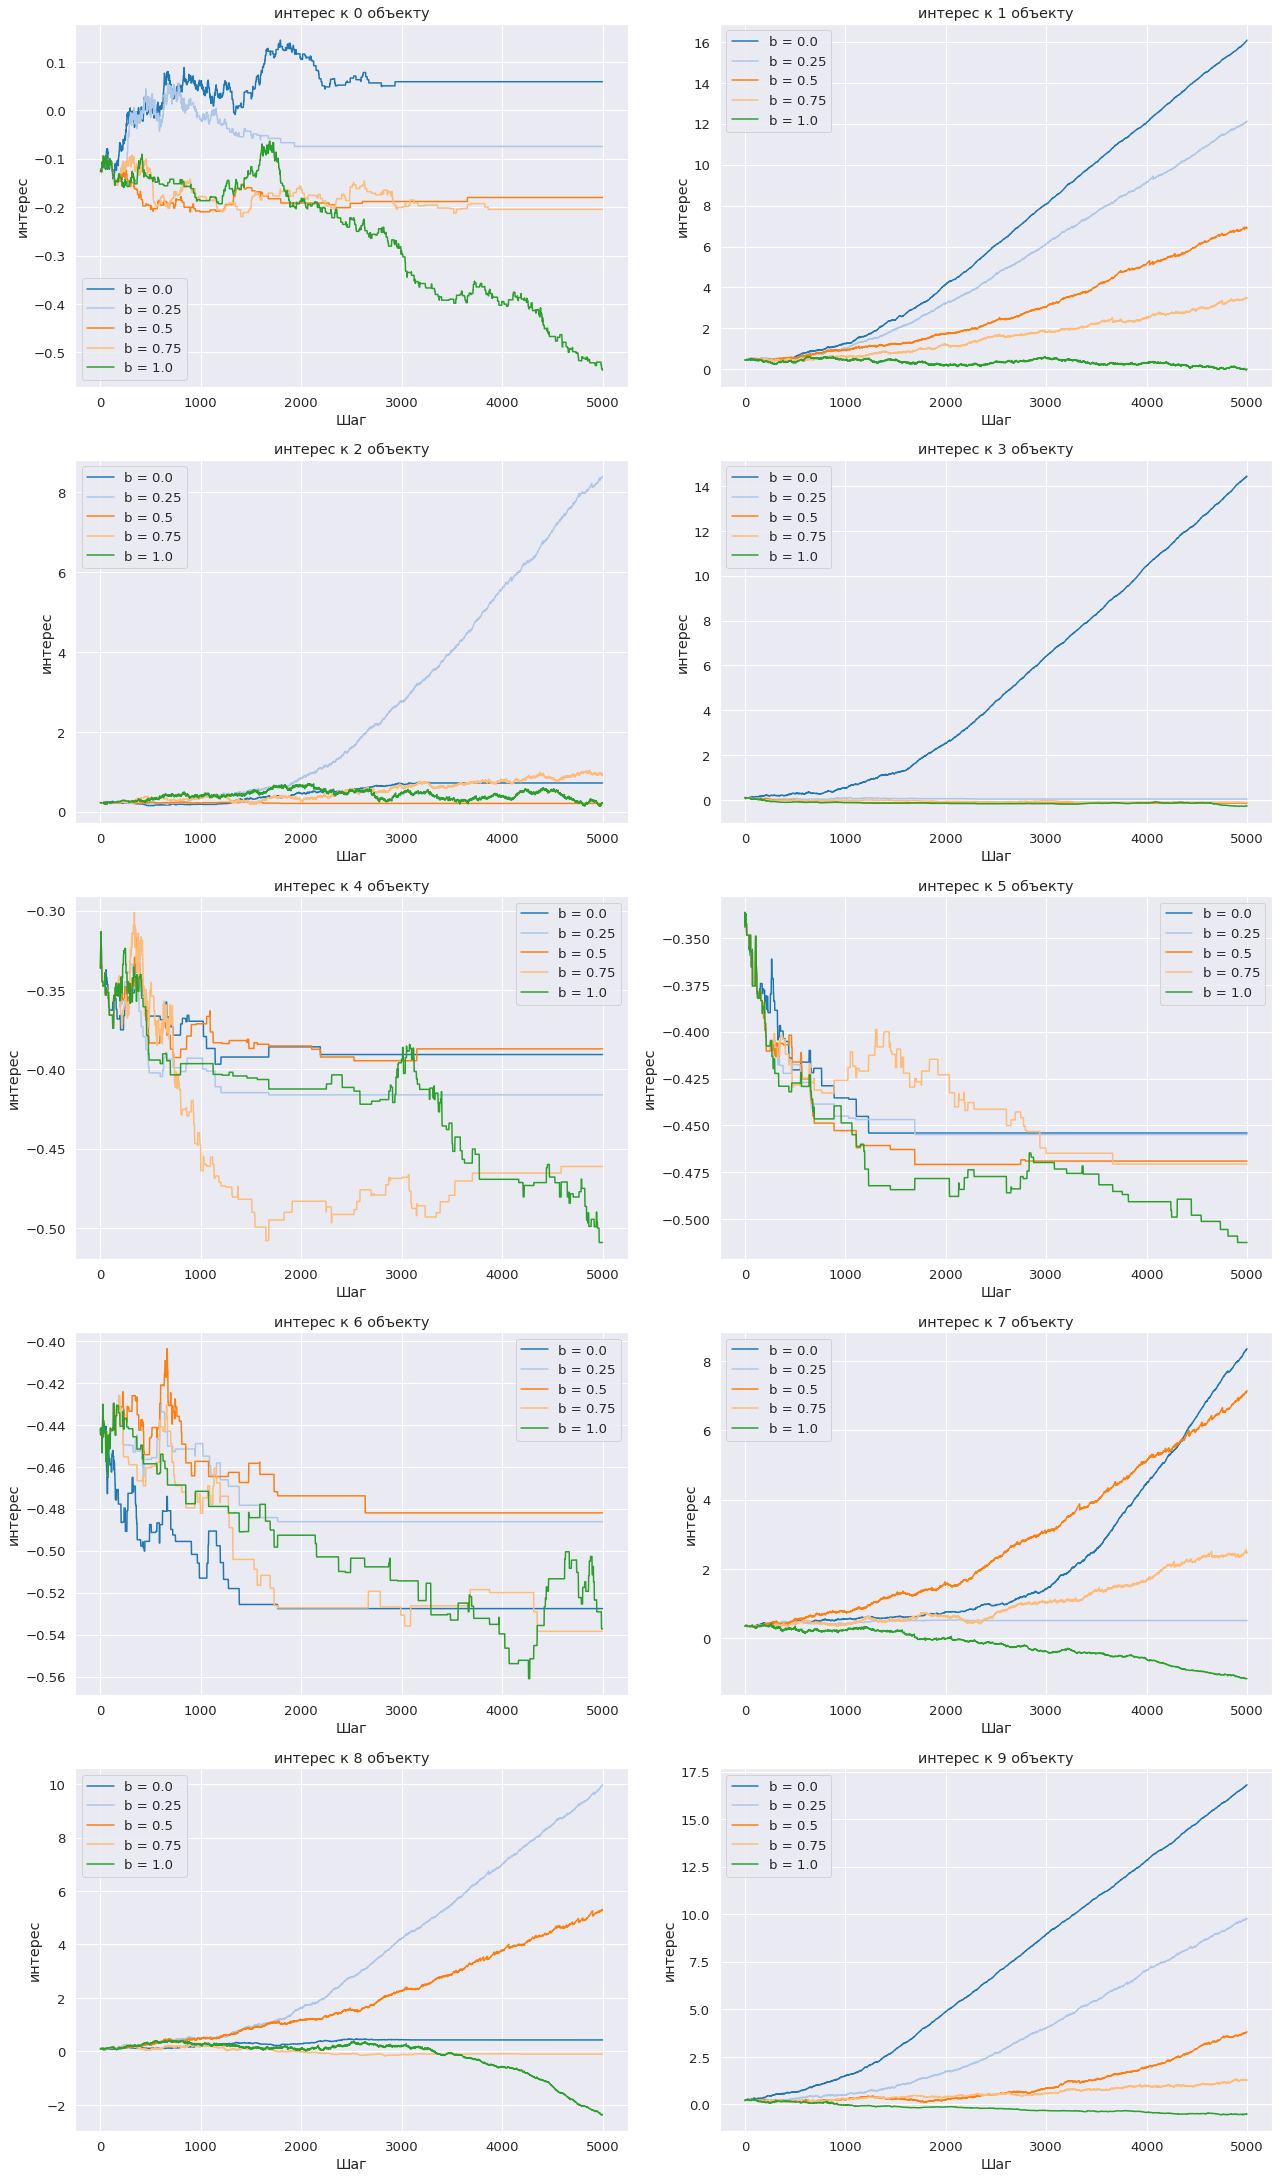

In [14]:
plt.figure(figsize=(18, 36))
for m in range(M):
    plt.subplot(M // 2 + 1, 2, m+1)
    for i, b in enumerate(bs):
        plt.plot(interests[i][:, m], label=f'b = {b}')
    plt.title(f'интерес к {m} объекту')
    plt.ylabel('интерес')
    plt.xlabel('Шаг')
    plt.legend()

    plt.tight_layout()

Text(0.5, 0, 'Шаг')

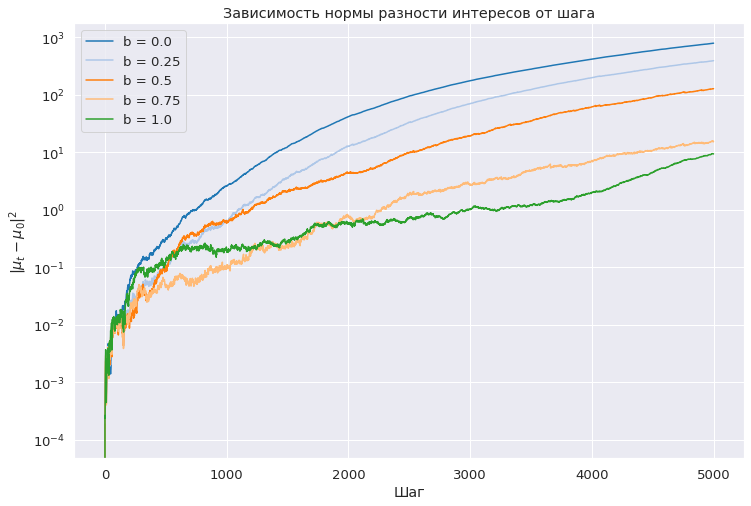

In [15]:
plt.figure(figsize=(12, 8))
for i, b in enumerate(bs):
    plt.plot(np.linalg.norm(interests[i] - interests[i][0], axis=1)**2, label=f'b = {round(b,3)}')
plt.yscale('log')
plt.ylabel(r'$\|\mu_t - \mu_0 \|^2$')
plt.title('Зависимость нормы разности интересов от шага')
plt.legend()
plt.xlabel('Шаг')
# plt.savefig('norm_interest.pdf')